In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from numpy.random import normal, binomial
from itertools import combinations, product

## Functions to generate dataset

In [2]:
def gen_A(seed, N, prob_priv=0.6):
    '''
    Function to generate race (A)
    A has no parent nodes
    '''
    
    # Set random seed for race generation
    np.random.seed(seed)
    
    # Generate race with binomial (only 2 races)
    # White (privileged) encoded as 1, Black encoded as 0
    return binomial(n=1, p=prob_priv, size=N)

def gen_Err(seed, N, mu=0, sd=1):
    '''
    Function to generate noise node (Epsilon-X or Epsilon-Y)
    Error nodes have no parent nodes
    
    Note: "epsilon," "error," and "noise" are used interchangeably
    '''
    
    # Set random seed for noise generation
    np.random.seed(seed)
    
    # Noise is Gaussian
    return normal(loc=mu, scale=sd, size=N)

def gen_X(seed, a, err_input, err=None,
          base_mu=150, base_sd=10, 
          a_boost_coeff=2, a_boost_sd=1):
    '''
    Function to generate LSAT scores (X)
    A is parent of X
    
    If err_input==False, then A is the only parent of X
    If err_input==True, then Epsilon-X is also a parent of X
    '''
    
    # Set random seed for LSAT score generation
    np.random.seed(seed)
    
    # Get dataset size from length of race vector
    N = len(a)
    
    # Base LSAT score, without race input, is Gaussian
    base_score = normal(loc=base_mu, scale=base_sd, size=N)
    
    # Boost from race=1 is Gaussian, centered on r_boost_coeff*r
    race_boost = normal(loc=a_boost_coeff*a, scale=a_boost_sd, size=N)
    
    # Add boost to base
    boosted_score = base_score+race_boost
    
    # Add noise if DAG specifies S is child of error node
    if err_input:
        boosted_score = boosted_score + err
        
    # Bound scores between 120 and 180, turn to int
    capped_score = np.rint(np.minimum(np.maximum(120, boosted_score), 180))
    return capped_score
    
def gen_Y(seed, a, x, err_input, err=None,
          base_mu=3, base_sd=0.5, 
          x_boost_power=0.25, x_boost_sd=0.25,
          a_detract_coeff=0.25, a_detract_sd=0.25):
    '''
    Function to generate 1L GPAs (Y)
    A and X are parents of Y
    
    If err_input==False, then A and X are the only parents of Y
    If err_input==True, then Epsilon-Y is also a parent of Y
    '''
    
    # Set random seed for GPA generation
    np.random.seed(seed)
    
    # Get dataset size from length of race vector
    N = len(a)
    
    # Base GPA, without input from LSAT or race, is Gaussian
    base_grade = normal(loc=base_mu, scale=base_sd, size=N)
    
    # Boost from LSAT score is Gaussian, centered on a power of the score
    score_boost = normal(np.power(x, x_boost_power), x_boost_sd, size=N)
    
    # Add score boost to base
    boosted_grade = base_grade + score_boost
    
    # Detraction for race=0 is Gaussian, centered on r_detract_coeff*(1-r)
    race_detract = normal(loc=a_detract_coeff*(1-a), scale=a_detract_sd, size=N)
    
    # Subract race detraction from score-boosted base
    detracted_grade = boosted_grade - race_detract
    
    # Add noise if DAG specifies Y is child of error node
    if err_input:
        detracted_grade = detracted_grade + err
        
    # Rescale GPA from 0 to 4
    zeroed_grade = detracted_grade+(0-detracted_grade.min())
    gpa_scaled = 4*zeroed_grade/zeroed_grade.max()
    return(gpa_scaled)

def gen_data(a_seed, y_err_seed, x_err_seed, y_seed, x_seed, # random seeds can be set seperately
             x_err_input, y_err_input, # which nodes receive noise as input (X and/or Y)
             x_err_mu=0, x_err_sd=1, # X-noise settings
             y_err_mu=0, y_err_sd=0.25, # Y-noise settings
             N=10, prob_priv=0.6, # gender settings
             x_base_mu=150, x_base_sd=10, # score settings
             x_a_boost_coeff=2, x_a_boost_sd=1, # more score settings
             y_base_mu=3, y_base_sd=0.5, # gpa settings
             y_x_boost_power=0.25, y_x_boost_sd=0.25, # more gpa settings
             y_a_detract_coeff=.25, y_a_detract_sd=0.25): # even more gpa settings
    '''
    Function to generate dataset: A, Epsilon-X, Epsilon-Y, X, and Y
    Returns dataframe including rank of Y (allows ties)
    '''
    
    # Generate race node (A)
    a = gen_A(seed=a_seed, N=N, prob_priv=prob_priv)
    
    if y_err_input:
        # Generate noise node to be parent of Y (Epsilon-Y)
        y_err = gen_Err(seed=y_err_seed, mu=y_err_mu, sd=y_err_sd, N=N)
    else:
        y_err=None
        
    if x_err_input:
        # Generate noise node to be parent of X (Epsilon-X)
        x_err = gen_Err(seed=x_err_seed, mu=x_err_mu, sd=x_err_sd, N=N)
    else:
        x_err=None
    
    # Generate LSAT score node (X)
    x = gen_X(seed=x_seed, a=a, err_input = x_err_input, err=x_err,
              base_mu=x_base_mu, base_sd=x_base_sd, 
              a_boost_coeff=x_a_boost_coeff, a_boost_sd=x_a_boost_sd)
    
    # Generate first-year GPA node (Y)
    y = gen_Y(seed=y_seed, a=a, x=x, err_input = y_err_input, err=y_err,
              base_mu=y_base_mu, base_sd=y_base_sd, 
              x_boost_power = y_x_boost_power, x_boost_sd=y_x_boost_sd,
              a_detract_coeff = y_a_detract_coeff, a_detract_sd = y_a_detract_sd)
    
    # Compile columns into dataframe
    data = pd.DataFrame({'a':a, 'x_err': x_err, 'y_err': y_err, 'x':x, 'y':y})
    
    # Calculate rank
    data['rank']=data['y'].rank(ascending=False) # Tied ranks are possible
    
    return(data)

## Functions to analyze generated datasets

In [3]:
def percent_nonpriv_at_top_k(data, k):
    '''
    Calculate the percentage of individuals in the top k that are non-privileged
    '''
    top_k = data[data['rank']<=k]
    portion_nonpriv = len(top_k[top_k['a']==0])/k
    return 100*portion_nonpriv

def plot_data(data):
    # Create scatterplot
    sc = plt.scatter(data.x, data.y, c=data.a)

    # Label axes
    plt.xlabel('LSAT score', size=14)
    plt.ylabel('1L GPA', size=14)

    # Set legend marker size
    size=81

    # Dict for converting R value to race
    race_dict = {1:'White', 0:'Black'}

    # Create dummy handles for legend
    # adapted from SO:
    # https://stackoverflow.com/questions/44595288/matplotlib-adding-legend-based-on-existing-color-series
    lp = lambda i: plt.plot([], color=sc.cmap(sc.norm(i)), ms=np.sqrt(size), mec='none',
                label=race_dict[i], ls='', marker='o')[0]
    handles = [lp(i) for i in np.unique(data['a'])]

    # Add legend
    plt.legend(handles=handles)

    # Display scatterplot
    plt.show()

## Function to generate dataset and re-sample rankings

In [4]:
def noise_sim(num_runs, x_err_input, y_err_input,
            x_seed_constant, y_seed_constant, 
            a_seed_constant=True, N=100, k=10,
            display_data=False):
    '''
    Generate dataset and sample num_runs-1 re-rankings derived from additional datasets
    '''

    # Set initial seeds
    x_seed=0
    y_seed=num_runs
    a_seed=num_runs*2
    x_err_seed=num_runs*3 # will not be used unless x_err_input==True
    y_err_seed=num_runs*4 # will not be used unless y_err_input==True
    
    # Generate baseline dataset with initial seeds
    data = gen_data(y_err_seed=y_err_seed,  x_err_seed=x_err_seed,
                        x_seed=x_seed, y_seed=y_seed, a_seed=a_seed, 
                        x_err_input=x_err_input, y_err_input=y_err_input, N=N)
    
    if display_data:
        display(data) # Display dataframe
        plot_data(data) # Display scatterplot
        print('Percent Black in top {}: {:0.2f}%'.format(k, percent_nonpriv_at_top_k(data, k)))
    
    # Generate additional datasets
    for i in range(1, num_runs):
        
        if x_err_input:
            # Increment random seed for S-noise node
            x_err_seed +=1
            
        if y_err_input:
            # Increment random seed for Y-noise node
            y_err_seed +=1
        
        if not a_seed_constant:
            # Increment random seed for race (A)
            a_seed +=1
        
        if not x_seed_constant:
            # Increment random seed for LSAT score (X)
            x_seed +=1
            
        if not y_seed_constant:
            # Increment random seed for GPA (Y)
            y_seed +=1
 
    
        # Generate dataset with non-constant seeds incremented
        sim = gen_data(y_err_seed=y_err_seed,  x_err_seed=x_err_seed,
                        x_seed=x_seed, y_seed=y_seed, a_seed=a_seed, 
                        x_err_input=x_err_input, y_err_input=y_err_input, N=N)
        
        # Add this ranking to the original dataframe
        data['rank_'+str(i)] = sim['rank']
        
        if display_data:
            display(sim) # Display dataframe
            plot_data(sim) # Display scatterplot
            print('Percent Black in top {}: {:0.2f}%'.format(k, percent_nonpriv_at_top_k(sim, k)))
      
    return data

## Visualize data distribution under different assumptions

,a,x_err,y_err,x,y,rank
0,0,None,0.118246,168.0,2.751664,126.0
1,1,None,-0.170356,157.0,2.442167,254.0
2,0,None,0.060610,159.0,1.375732,848.0
3,1,None,-0.425184,175.0,0.761782,971.0
4,1,None,0.188286,171.0,1.551794,762.0
...,...,...,...,...,...,...
995,1,None,0.099569,156.0,1.605470,734.0
996,1,None,0.182397,151.0,2.241479,360.0
997,1,None,0.214513,153.0,2.746595,128.0
998,0,None,0.249910,137.0,2.020530,495.0


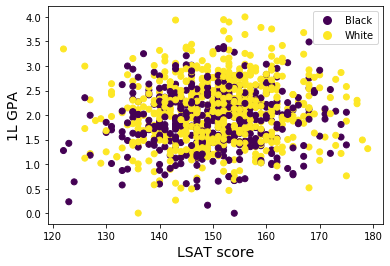

Percent Black in top 200: 28.00%


,a,x_err,y_err,x,y,rank
0,0,None,-0.178098,168.0,2.222005,232.0
1,1,None,0.188442,157.0,2.519629,105.0
2,0,None,-0.011126,159.0,1.059203,862.0
3,1,None,0.112953,175.0,1.011701,887.0
4,1,None,0.336275,171.0,1.437786,699.0
...,...,...,...,...,...,...
995,1,None,0.080377,156.0,1.336634,748.0
996,1,None,-0.043493,151.0,1.778981,488.0
997,1,None,-0.333731,153.0,1.983987,355.0
998,0,None,-0.377549,137.0,1.187510,810.0


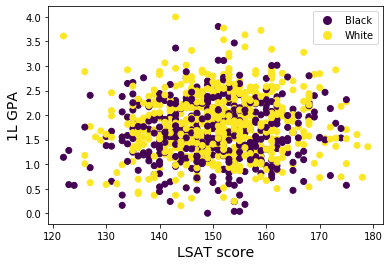

Percent Black in top 200: 32.00%


,a,x_err,y_err,x,y,rank
0,0,None,0.387835,168.0,3.143266,47.0
1,1,None,0.019797,157.0,2.733188,155.0
2,0,None,0.043494,159.0,1.386194,855.0
3,1,None,-0.018084,175.0,1.150720,916.0
4,1,None,-0.501082,171.0,0.906709,959.0
...,...,...,...,...,...,...
995,1,None,-0.060906,156.0,1.489587,808.0
996,1,None,0.053929,151.0,2.201909,412.0
997,1,None,0.330328,153.0,2.985071,88.0
998,0,None,-0.097295,137.0,1.748186,679.0


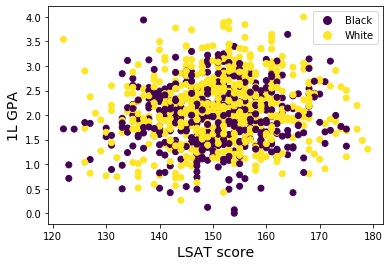

Percent Black in top 200: 31.50%


,a,x_err,y_err,x,y,rank,rank_1,rank_2
0,0,None,0.118246,168.0,2.751664,126.0,232.0,47.0
1,1,None,-0.170356,157.0,2.442167,254.0,105.0,155.0
2,0,None,0.060610,159.0,1.375732,848.0,862.0,855.0
3,1,None,-0.425184,175.0,0.761782,971.0,887.0,916.0
4,1,None,0.188286,171.0,1.551794,762.0,699.0,959.0
...,...,...,...,...,...,...,...,...
995,1,None,0.099569,156.0,1.605470,734.0,748.0,808.0
996,1,None,0.182397,151.0,2.241479,360.0,488.0,412.0
997,1,None,0.214513,153.0,2.746595,128.0,355.0,88.0
998,0,None,0.249910,137.0,2.020530,495.0,810.0,679.0


In [5]:
# Generate 3 datasets with error node as parent of Y
# All is constant except seed on Y-noise error node
noise_sim(num_runs=3, x_err_input=False, y_err_input=True, 
            x_seed_constant=True, y_seed_constant=True, a_seed_constant=True,
            N=1000, k=200, display_data=True)

,a,x_err,y_err,x,y,rank
0,0,None,0.118246,168.0,2.751664,126.0
1,1,None,-0.170356,157.0,2.442167,254.0
2,0,None,0.060610,159.0,1.375732,848.0
3,1,None,-0.425184,175.0,0.761782,971.0
4,1,None,0.188286,171.0,1.551794,762.0
...,...,...,...,...,...,...
995,1,None,0.099569,156.0,1.605470,734.0
996,1,None,0.182397,151.0,2.241479,360.0
997,1,None,0.214513,153.0,2.746595,128.0
998,0,None,0.249910,137.0,2.020530,495.0


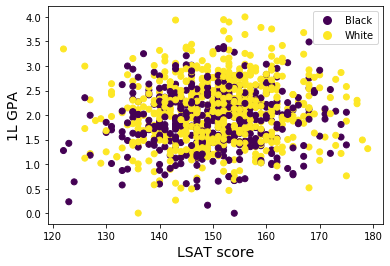

Percent Black in top 200: 28.00%


,a,x_err,y_err,x,y,rank
0,0,None,-0.178098,166.0,1.489642,668.0
1,1,None,0.188442,143.0,1.916544,403.0
2,0,None,-0.011126,145.0,0.496811,971.0
3,1,None,0.112953,141.0,1.858019,440.0
4,1,None,0.336275,159.0,2.198463,255.0
...,...,...,...,...,...,...
995,1,None,0.080377,151.0,1.797866,485.0
996,1,None,-0.043493,130.0,2.560657,124.0
997,1,None,-0.333731,150.0,0.734724,928.0
998,0,None,-0.377549,154.0,1.615837,600.0


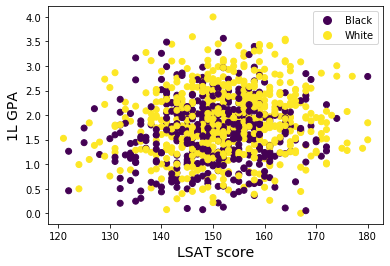

Percent Black in top 200: 27.00%


,a,x_err,y_err,x,y,rank
0,0,None,0.387835,146.0,2.287003,230.0
1,1,None,0.019797,152.0,1.399366,772.0
2,0,None,0.043494,128.0,3.359053,12.0
3,1,None,-0.018084,169.0,1.842727,489.0
4,1,None,-0.501082,133.0,1.431855,755.0
...,...,...,...,...,...,...
995,1,None,-0.060906,153.0,2.366761,191.0
996,1,None,0.053929,158.0,2.422481,169.0
997,1,None,0.330328,151.0,2.021800,367.0
998,0,None,-0.097295,150.0,1.128780,885.0


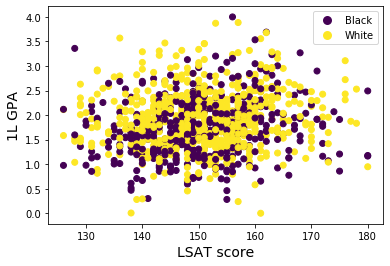

Percent Black in top 200: 34.50%


,a,x_err,y_err,x,y,rank,rank_1,rank_2
0,0,None,0.118246,168.0,2.751664,126.0,668.0,230.0
1,1,None,-0.170356,157.0,2.442167,254.0,403.0,772.0
2,0,None,0.060610,159.0,1.375732,848.0,971.0,12.0
3,1,None,-0.425184,175.0,0.761782,971.0,440.0,489.0
4,1,None,0.188286,171.0,1.551794,762.0,255.0,755.0
...,...,...,...,...,...,...,...,...
995,1,None,0.099569,156.0,1.605470,734.0,485.0,191.0
996,1,None,0.182397,151.0,2.241479,360.0,124.0,169.0
997,1,None,0.214513,153.0,2.746595,128.0,928.0,367.0
998,0,None,0.249910,137.0,2.020530,495.0,600.0,885.0


In [6]:
# Generate 3 datasets with error node as parent of Y
# All random seeds vary with each run, except for race
noise_sim(num_runs=3, x_err_input=False, y_err_input=True, 
          x_seed_constant=False, y_seed_constant=False, a_seed_constant=True,
          N=1000, k=200, display_data=True)

,a,x_err,y_err,x,y,rank
0,0,0.001109,None,168.0,2.582796,135.0
1,1,-0.289544,None,157.0,2.535694,149.0
2,0,-1.116066,None,158.0,1.077150,886.0
3,1,-0.012883,None,175.0,0.898305,930.0
4,1,-0.378361,None,171.0,1.148272,860.0
...,...,...,...,...,...,...
995,1,-0.547119,None,156.0,1.302565,801.0
996,1,-0.154734,None,151.0,1.936644,461.0
997,1,-0.057486,None,153.0,2.475678,172.0
998,0,-0.999350,None,136.0,1.608383,660.0


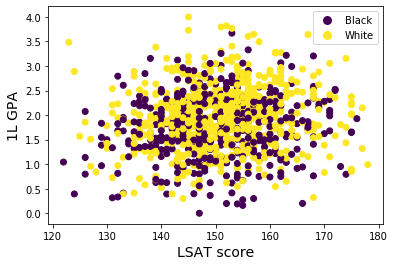

Percent Black in top 200: 29.00%


,a,x_err,y_err,x,y,rank
0,0,1.331587,None,170.0,2.604260,134.0
1,1,0.715279,None,158.0,2.551514,147.0
2,0,-1.545400,None,158.0,1.077739,885.0
3,1,-0.008384,None,175.0,0.897756,931.0
4,1,0.621336,None,172.0,1.154903,857.0
...,...,...,...,...,...,...
995,1,-1.014339,None,155.0,1.298571,801.0
996,1,-0.331828,None,151.0,1.942696,460.0
997,1,1.440697,None,155.0,2.497277,167.0
998,0,-0.390218,None,137.0,1.618982,655.0


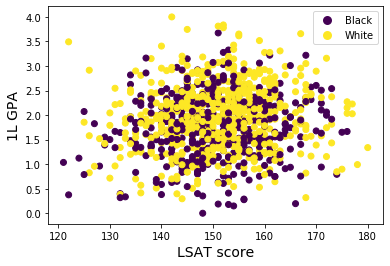

Percent Black in top 200: 29.00%


,a,x_err,y_err,x,y,rank
0,0,1.749455,None,170.0,2.597905,134.0
1,1,-0.286073,None,157.0,2.539203,150.0
2,0,-0.484565,None,159.0,1.077389,882.0
3,1,-2.653319,None,172.0,0.874860,932.0
4,1,-0.008285,None,171.0,1.143029,861.0
...,...,...,...,...,...,...
995,1,-1.540007,None,155.0,1.292280,801.0
996,1,0.671642,None,152.0,1.942508,454.0
997,1,-0.178375,None,153.0,2.478808,170.0
998,0,-0.718629,None,137.0,1.612676,656.0


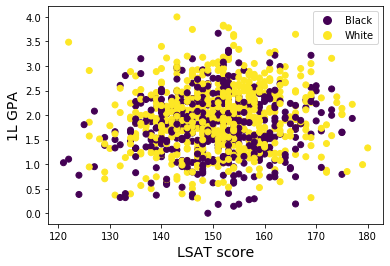

Percent Black in top 200: 29.00%


,a,x_err,y_err,x,y,rank,rank_1,rank_2
0,0,0.001109,None,168.0,2.582796,135.0,134.0,134.0
1,1,-0.289544,None,157.0,2.535694,149.0,147.0,150.0
2,0,-1.116066,None,158.0,1.077150,886.0,885.0,882.0
3,1,-0.012883,None,175.0,0.898305,930.0,931.0,932.0
4,1,-0.378361,None,171.0,1.148272,860.0,857.0,861.0
...,...,...,...,...,...,...,...,...
995,1,-0.547119,None,156.0,1.302565,801.0,801.0,801.0
996,1,-0.154734,None,151.0,1.936644,461.0,460.0,454.0
997,1,-0.057486,None,153.0,2.475678,172.0,167.0,170.0
998,0,-0.999350,None,136.0,1.608383,660.0,655.0,656.0


In [7]:
# Generate 3 datasets with error node as parent of X
# All is constant except seed on X-noise error node
noise_sim(num_runs=3, x_err_input=True, y_err_input=False, 
            x_seed_constant=True, y_seed_constant=True, a_seed_constant=True,
            N=1000, k=200, display_data=True)

,a,x_err,y_err,x,y,rank
0,0,0.001109,None,168.0,2.582796,135.0
1,1,-0.289544,None,157.0,2.535694,149.0
2,0,-1.116066,None,158.0,1.077150,886.0
3,1,-0.012883,None,175.0,0.898305,930.0
4,1,-0.378361,None,171.0,1.148272,860.0
...,...,...,...,...,...,...
995,1,-0.547119,None,156.0,1.302565,801.0
996,1,-0.154734,None,151.0,1.936644,461.0
997,1,-0.057486,None,153.0,2.475678,172.0
998,0,-0.999350,None,136.0,1.608383,660.0


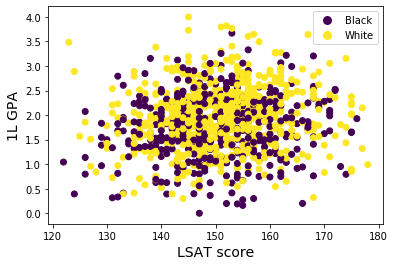

Percent Black in top 200: 29.00%


,a,x_err,y_err,x,y,rank
0,0,1.331587,None,167.0,1.651223,563.0
1,1,0.715279,None,144.0,1.715163,525.0
2,0,-1.545400,None,144.0,0.371311,983.0
3,1,-0.008384,None,141.0,1.727603,520.0
4,1,0.621336,None,160.0,1.859969,426.0
...,...,...,...,...,...,...
995,1,-1.014339,None,150.0,1.691339,536.0
996,1,-0.331828,None,129.0,2.659462,103.0
997,1,1.440697,None,152.0,1.004931,872.0
998,0,-0.390218,None,154.0,2.002257,346.0


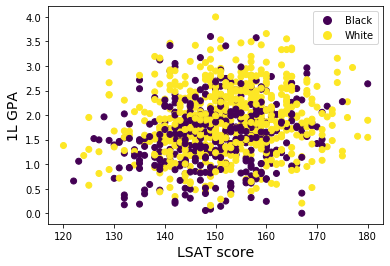

Percent Black in top 200: 24.50%


,a,x_err,y_err,x,y,rank
0,0,1.749455,None,148.0,2.044122,442.0
1,1,-0.286073,None,151.0,1.398352,807.0
2,0,-0.484565,None,128.0,3.591702,11.0
3,1,-2.653319,None,166.0,1.926690,528.0
4,1,-0.008285,None,133.0,1.970008,492.0
...,...,...,...,...,...,...
995,1,-1.540007,None,152.0,2.572080,161.0
996,1,0.671642,None,158.0,2.524164,181.0
997,1,-0.178375,None,150.0,1.785311,606.0
998,0,-0.718629,None,150.0,1.217813,875.0


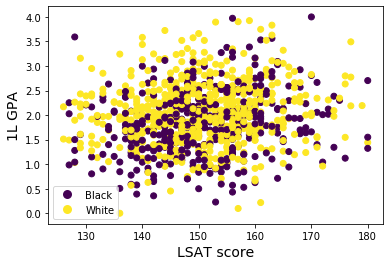

Percent Black in top 200: 32.00%


,a,x_err,y_err,x,y,rank,rank_1,rank_2
0,0,0.001109,None,168.0,2.582796,135.0,563.0,442.0
1,1,-0.289544,None,157.0,2.535694,149.0,525.0,807.0
2,0,-1.116066,None,158.0,1.077150,886.0,983.0,11.0
3,1,-0.012883,None,175.0,0.898305,930.0,520.0,528.0
4,1,-0.378361,None,171.0,1.148272,860.0,426.0,492.0
...,...,...,...,...,...,...,...,...
995,1,-0.547119,None,156.0,1.302565,801.0,536.0,161.0
996,1,-0.154734,None,151.0,1.936644,461.0,103.0,181.0
997,1,-0.057486,None,153.0,2.475678,172.0,872.0,606.0
998,0,-0.999350,None,136.0,1.608383,660.0,346.0,875.0


In [8]:
# Generate 3 datasets with error node as parent of X
# All random seeds vary with each run, except for race
noise_sim(num_runs=3, x_err_input=True, y_err_input=False, 
          x_seed_constant=False, y_seed_constant=False, a_seed_constant=True,
          N=1000, k=200, display_data=True)

## Find expected Kendall's tau between original datasets and sampled re-rankings

In [9]:
def kendalls_tau(rank1, rank2):
    
    '''
    Calculate Kendall's Tau Rank Coefficient for 2 ranking permutations
    
    Note: Does not handle ties
    
    Could be converted from O(N^2) time to O(NlogN) time using Christensen's algorithm:
    https://link.springer.com/article/10.1007/BF02736122
    '''
    
    # Initialize number of concordant/discordant pairs
    concordant = 0
    discordant = 0
    
    # Loop through all combinations of row indices
    for i, j in combinations(rank1.index, 2):
        
        # Pair is concordant if ordered same way in rank1 and rank 2
        if ((rank1[i]<rank1[j]) & (rank2[i]<rank2[j])) or ((rank1[i]>rank1[j]) & (rank2[i]>rank2[j])):
            concordant+=1
            
        # Pair is discordant if ordered differently in rank1 and rank 2   
        else:
            discordant+=1
            
    return (concordant - discordant)/(concordant+discordant)

In [10]:
def expected_kendalls_tau(N, num_runs, noise_child, constant):
    
     '''
    Generate dataset and calculate expected Kendall's Tau
    '''
    
    # Set which node (Y or X) is the sole child of the error node
    if noise_child=='Y':
        x_err_input=False
        y_err_input=True
    elif noise_child=='X':
        x_err_input=True
        y_err_input=False
        
    if constant:
        # If constant: all data is held constant except seed on error node
        x_seed_constant=True
        y_seed_constant=True
        var_descrip = 'all data is held constant except random seed on error node,'
    else:
        # If not constant: all seeds incremented for each run, except seed for race
        x_seed_constant=False
        y_seed_constant=False
        var_descrip = 'all random seeds incremented for each run (except seed for race),'
    

    # Generate num_runs datasets
    df = noise_sim(N=N, num_runs=num_runs, 
                   x_err_input=x_err_input, y_err_input=y_err_input, 
                   x_seed_constant=x_seed_constant, y_seed_constant=y_seed_constant, 
                   a_seed_constant=True)

    # Initialize empty list of Kendall's Tau Rank Coefficients
    kts = []

    # List non-original ranking columns from simulations
    re_rankings = [x for x in df.columns if 'rank_' in x]

    # Get Kendall's Tau for each re-ranking, as compared to original ranking
    for col in re_rankings:
        kts.append(kendalls_tau(df['rank'], df[col]))

    print('N={}, noise node as parent of {},'.format(N, noise_child),
          var_descrip, '{} runs\n'.format(num_runs),
          '\tExpected Kendall\'s tau rank coefficient: {:0.3f}'.format(np.mean(kts)),
          '\n\tStandard deviation of Kendall\'s tau: {:0.3f}\n'.format(np.std(kts)))
    
    # Estimate expected Kendall's Tau with mean
    return(np.mean(kts))

In [11]:
# Set number of runs (including original)
num_runs=1001

# Create parameter grid
Ns=[10, 25, 100]
noise_children = ['Y', 'X']
constants = [True, False]
params = list(product(Ns, constants, noise_children))

# Initialize empty list of expected Kendall's taus
exp_kts = []

# Get expected Kendall's tau for each configuration in param grid
for N, constant, noise_child in params:
    exp_kts.append(expected_kendalls_tau(N=N, num_runs=1001, noise_child=noise_child, constant=constant))

N=10, noise node as parent of Y, all data is held constant except random seed on error node, 1001 runs
 	Expected Kendall's tau rank coefficient: 0.819 
	Standard deviation of Kendall's tau: 0.078

N=10, noise node as parent of X, all data is held constant except random seed on error node, 1001 runs
 	Expected Kendall's tau rank coefficient: 0.961 
	Standard deviation of Kendall's tau: 0.034

N=10, noise node as parent of Y, all random seeds incremented for each run (except seed for race), 1001 runs
 	Expected Kendall's tau rank coefficient: 0.000 
	Standard deviation of Kendall's tau: 0.247

N=10, noise node as parent of X, all random seeds incremented for each run (except seed for race), 1001 runs
 	Expected Kendall's tau rank coefficient: 0.011 
	Standard deviation of Kendall's tau: 0.256

N=25, noise node as parent of Y, all data is held constant except random seed on error node, 1001 runs
 	Expected Kendall's tau rank coefficient: 0.661 
	Standard deviation of Kendall's tau: 0.065

In [30]:
# Create mult-index for results df columns
multi_cols = pd.MultiIndex.from_product([['Constant', 'Not Constant'], noise_children],
                           names=['Non-Noise Random Seeds', 'Noise Node Child'])

# Put results into df
exp_kt_df = pd.DataFrame(np.array(exp_kts).reshape((3, 4)), 
                         columns = multi_cols, 
                         index=['N=10', 'N=25', 'N=100'])

exp_kt_df

Non-Noise Random Seeds Constant           Not Constant          
Noise Node Child              Y         X            Y         X
N=10                    0.81920  0.960844     0.000356  0.011467
N=25                    0.66144  0.974200     0.016913  0.029780
N=100                   0.66654  0.992778     0.019314  0.030969

#### Note that all of the above holds fixed the parameters of the data-generationg process, except for which node Epsilon is the parent of.  "Constant" vs. "Not Constant" represents a difference in re-sampling methodology.

#### Next steps: Use CIFRank to generate fair rankings from original datasets, calculate Kendall's tau between original and fair, compare to expected Kendall's tau between original and re-sampled. Potentially repeat the entire process with different "original" samples, to estimate the expected difference between the two statistics.